In [1]:
# Importing Libraries
import numpy as np
import os
import cv2
import string
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [5]:
# Reading Text
f = open('/content/drive/MyDrive/parser.txt')
d = f.read()
f.close()
data = d.split('\n')
data

['a01-000u-00-00 ok 154 408 768 27 51 AT A',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.',
 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell',
 'a01-000u-00-06 ok 154 1896 757 173 72 IN from',
 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating',
 'a01-000u-01-01 ok 156 901 958 147 79 DTI any',
 'a01-000u-01-02 ok 156 1112 958 208 42 AP more',
 'a01-000u-01-03 ok 156 1400 937 294 59 NN Labour',
 'a01-000u-01-04 ok 156 1779 932 174 63 NN life',
 'a01-000u-01-05 ok 156 2008 933 237 70 NNS Peers',
 'a01-000u-02-00 ok 157 408 1106 65 70 BEZ is',
 'a01-000u-02-01 ok 157 541 1118 72 54 TO to',
 'a01-000u-02-02 ok 157 720 1114 113 63 BE be',
 'a01-000u-02-03 ok 157 916 1136 281 46 VBN made',
 'a01-000u-02-04 ok 157 1281 1117 80 59 IN at',
 'a01-000u-02-05 ok 157 1405 1140 64 35 AT a',
 'a01-000u-02-06 ok 157 1544 1115 339 96 NN meeting',
 'a

In [24]:
path='/content/sample_data/handwriting'
os.mkdir(path)
os.chdir(path)
os.getcwd()

'/content/sample_data/handwriting'

In [7]:
# Reading images
if not os.path.exists('images'):
  os.mkdir('/content/images')
os.chdir('/content/images')
!tar xfz "/content/drive/MyDrive/words.tgz" 
os.chdir('/content')

In [8]:
# Encoding charaters

characters = string.ascii_letters + string.digits + string.punctuation
def encoder(txt):
    output = []
    for index, character in enumerate(txt):
        output.append(characters.index(character))
    return output
print(characters,len(characters))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 94


In [9]:
#Preprocessing image file
def transform(image):
    width , height = image.shape

    new_width = 32
    new_height = int(height * (new_width / width))
    image = cv2.resize(image, (new_height , new_width))
    image = image.astype('float32') 
    width , height = image.shape

    if width < 32:
        add_zeros = np.full((32-width, height), 255)
        image = np.concatenate((image, add_zeros))
        width , height = image.shape

    if height < 128:
        add_zeros = np.full((width , 128-height), 255)
        image = np.concatenate((image, add_zeros), axis=1)
        width , height = image.shape

    if height > 128 or width > 32:
        dim = (128,32)
        image = cv2.resize(image, dim)

    image = cv2.subtract(255, image)
    # Expanding the dimension of image
    image = np.expand_dims(image, axis=2)
    # Normalize the image
    image = image / 255
    return image

In [10]:
#create train and validation images
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

max_len = 0

for index, line in enumerate(data):
    splits = line.split(' ')
    status = splits[1]
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        splits_id = word_id.split('-')
        filepath = '/content/images/{}/{}-{}/{}.png'.format(splits_id[0], splits_id[0], splits_id[1],word_id)
        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = transform(img)
        except:
            continue
        # processing on label
        try:
            label = encoder(word)
        except:
            continue
        if index % 10 == 0:
            valid_images.append(img)
            
            valid_labels.append(label)
            valid_input_length.append(31)
            # print(valid_input_length)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        if len(word) > max_len:
            max_len = len(word)
    if index >= 10000:
        break

In [11]:
# Pad the sequences
train_padded_label = pad_sequences(train_labels,
                                   maxlen = max_len,
                                   padding='post',
                                   value=len(characters))

valid_padded_label = pad_sequences(valid_labels,
                                   maxlen = max_len,
                                   padding='post',
                                   value=len(characters))

In [12]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

In [13]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

# Model Development

In [14]:
# Creating the model

inputs = Input(shape=(32,128,1))
conv_1 = Conv2D(64,(3,3),activation='relu',padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1) 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4) 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(characters)+1, activation = 'softmax')(blstm_2)

model = Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        590080

In [16]:
# Loss function
maxlen = max_len
labels = Input(name='labels', shape=[maxlen], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

# Model Training

In [17]:
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss)

In [18]:
batch_size = 16
epochs = 30
e = str(epochs)
optimizer = 'Adam'

In [19]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer, metrics=['accuracy'])
# callbacks function
filepath="models/model-{}e-{}o.h5".format(str(epochs),str(optimizer))
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [20]:
#train the model
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/30
491/491 [==============================] - 95s 110ms/step - loss: 14.7189 - accuracy: 0.0130 - val_loss: 13.7161 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 13.71605, saving model to models/model-30e-Adamo.h5
Epoch 2/30
491/491 [==============================] - 50s 101ms/step - loss: 12.0615 - accuracy: 0.0506 - val_loss: 12.9641 - val_accuracy: 0.0457

Epoch 00002: val_loss improved from 13.71605 to 12.96415, saving model to models/model-30e-Adamo.h5
Epoch 3/30
491/491 [==============================] - 50s 101ms/step - loss: 10.5487 - accuracy: 0.0746 - val_loss: 10.6221 - val_accuracy: 0.0982

Epoch 00003: val_loss improved from 12.96415 to 10.62206, saving model to models/model-30e-Adamo.h5
Epoch 4/30
491/491 [==============================] - 50s 101ms/step - loss: 9.0780 - accuracy: 0.1130 - val_loss: 8.9703 - val_accuracy: 0.1461

Epoch 00004: val_loss improved from 10.62206 to 8.97033, saving model to models/model-30e-Adamo.h5
Epoch 5/30
4

In [21]:
# Model Prediction
prediction_model = Model(model.get_layer(name="input_1").input, model.get_layer(name="dense").output)
prediction_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        5900

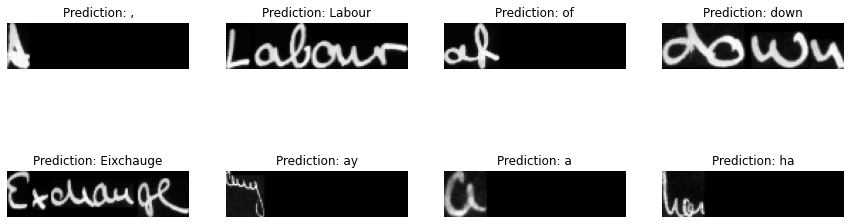

In [22]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    
    output_text = []
    for res in results:
        output_text.append(res)
    return output_text

preds = prediction_model.predict(valid_images)
pred_texts = decode_batch_predictions(preds)
wordlist = []
for preds in pred_texts:
  word = ''
  
  preds = preds.numpy()
  preds = preds[(preds != -1)]
  for val in preds:
    word = word+characters[val]
  wordlist.append(word)

_, ax = plt.subplots(2, 4, figsize=(15, 5))
for i in range(8):
        img = (valid_images[i, :, :, 0] * 255).astype(np.uint8)
        title = f"Prediction: {wordlist[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()